H I 😀

>This script is provided for **task 3**.

>This script is privately provided by Mohamad NAJAFI for the DiaDeep PhD applicant task. The task consists of three parts, and all the necessary scripts have been provided to achieve the requested results.
The description of task is provided as [Segmentation: WSI and U-Net Pipeline Manipulation](https://informationsharing.notion.siteSegmentation-WSI-and-U-Net-Pipeline-Manipulation-82a91afd8c24478f8be89c61bd04ba85).

> It should be mentioned that the main chalenges and important points are as follows for me:

- The 'annotation.csv' file cannot be read as a dataframe because all the data is stored in the first column of the CSV file. Additionally, there is an issue with reading the LINESTRING format of the geometry data. This requires parsing the data to obtain WKT or OPENCV geometry data, which needs to be addressed.
- I have expriences in tensorflow and leras for DML and DL application, however, I tried to not use tf libraries and just work with **torch** in this project.


> I am available and open to optimizing this script for various WSI image segmentation purposes. Having gained a better understanding of its functionality, I believe it would be applicable to focus on a specific class of annotation terms or a selected tissue for further refinement. Additionally, to achieve superior results, I've prepared a pilot format for fine-tuning SMP models using predefined weights. This can be applied on an augmented dataset generated by me from tiles of the original image, especially when ample image data is available and can be processed on a robust server.


> I am available to offer explanations or make modifications to this script based on your specific inquiry.

> Mohamad Najafi

In [1]:
# # These libraries sould be install specifically for this task purpose
# !pip install segmentation-models-pytorch
# !pip install pytorch-lightning==1.5.4
# !pip install torchtext==0.6.0

In [2]:
from google.colab import drive
from zipfile import ZipFile
from glob import glob
import os
import torch
import matplotlib.pyplot as plt
# import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import numpy as np
from pprint import pprint
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/TestDiaDeep

/content/drive/MyDrive/TestDiaDeep


In [5]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, mask_folder, transform=None):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform = transform

        self.images = sorted(os.listdir(image_folder))
        self.masks = sorted(os.listdir(mask_folder))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.images[idx])
        mask_path = os.path.join(self.mask_folder, self.masks[idx])

        image = Image.open(img_path)
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return {'image': image, 'mask': mask}



In [6]:
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [7]:
dataset_path = "/content/drive/MyDrive/TestDiaDeep/new_data_Morph_256_1"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "test")


from torch.utils.data import DataLoader

train_dataset = CustomDataset(train_path+'/image', train_path+'/mask', transform=data_transform)
val_dataset = CustomDataset(valid_path+'/image', valid_path+'/mask', transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

> Train a model without pretrained weights of imagenet

In [8]:
model_res = smp.Unet('resnet34', in_channels=3, classes=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_res.parameters(), lr=0.001)

In [9]:
num_epochs = 10
AV_val_losses_model = []

In [10]:
for epoch in range(num_epochs):
    model_res.train()
    for i, batch in enumerate(train_loader):
        images, masks = batch['image'], batch['mask']
        outputs = model_res(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # #Print progress
        # print(f'Training Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    model_res.eval()
    val_losses = []
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            images, masks = batch['image'], batch['mask']
            outputs = model_res(images)
            val_loss = criterion(outputs, masks)
            val_losses.append(val_loss.item())

            # # Print progress
            # print(f'Validation Batch [{i+1}/{len(val_loader)}], Val Loss: {val_loss.item():.4f}')

    avg_val_loss = sum(val_losses) / len(val_losses)
    AV_val_losses_model.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}')


Epoch [1/10], Loss: 0.1622, Val Loss: 0.5801
Epoch [2/10], Loss: 0.1305, Val Loss: 0.7271
Epoch [3/10], Loss: 0.1166, Val Loss: 1.0088
Epoch [4/10], Loss: 0.1500, Val Loss: 0.1450
Epoch [5/10], Loss: 0.2197, Val Loss: 0.0714
Epoch [6/10], Loss: 0.1079, Val Loss: 2.1865
Epoch [7/10], Loss: 0.1070, Val Loss: 0.0824
Epoch [8/10], Loss: 0.1613, Val Loss: 0.0758
Epoch [9/10], Loss: 0.0991, Val Loss: 0.0908
Epoch [10/10], Loss: 0.0896, Val Loss: 1.5785


In [11]:
torch.save(model_res.state_dict(), 'segmentation_model_res.pth')

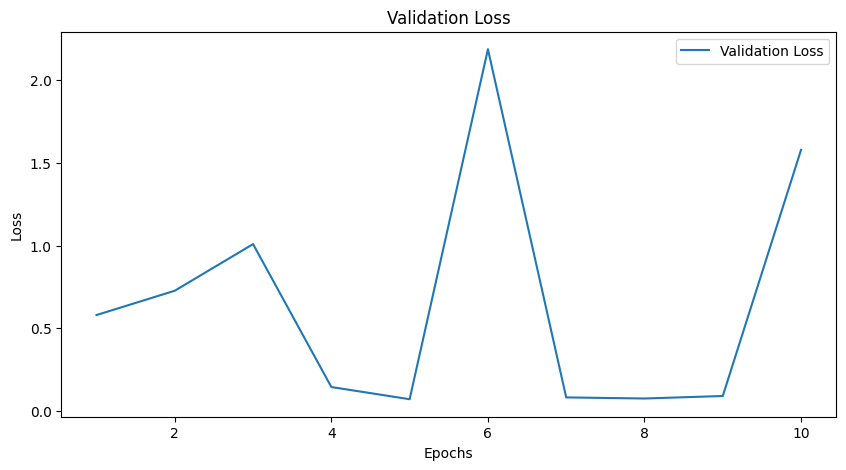

In [13]:
# Plot validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), AV_val_losses_model, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

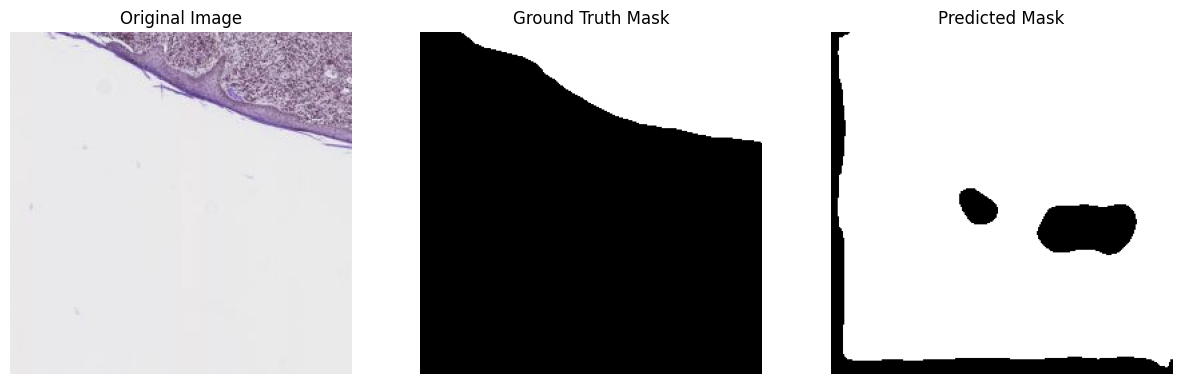

In [20]:
import matplotlib.pyplot as plt
import random
# Set model to evaluation mode
model_res.eval()

# Get a random sample from the validation set
sample = val_dataset[random.randint(0, len(val_dataset))]

# Extract image and mask
image = sample['image'].unsqueeze(0)  # Add batch dimension
mask = sample['mask'].unsqueeze(0)    # Add batch dimension

# Make prediction
with torch.no_grad():
    prediction = model_res(image)

# Convert prediction to binary mask
predicted_mask = torch.sigmoid(prediction) > 0.5

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image.squeeze(0).permute(1, 2, 0))
axes[0].set_title('Original Image')

axes[1].imshow(mask.squeeze(0).squeeze(0), cmap='gray')
axes[1].set_title('Ground Truth Mask')

axes[2].imshow(predicted_mask.squeeze(0).squeeze(0), cmap='gray')
axes[2].set_title('Predicted Mask')

for ax in axes:
    ax.axis('off')

plt.show()


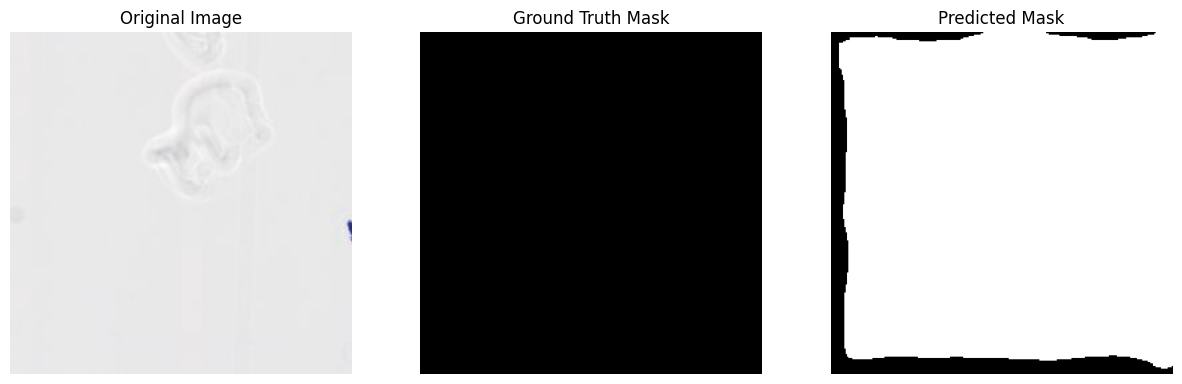

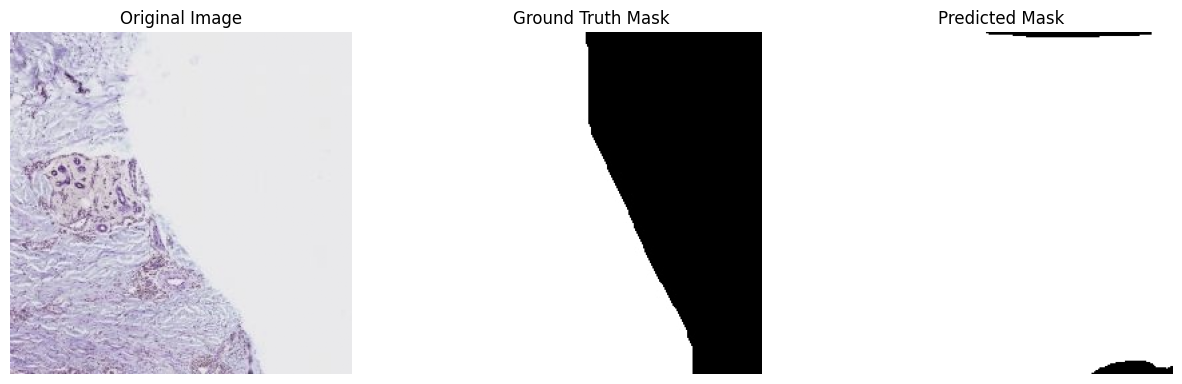

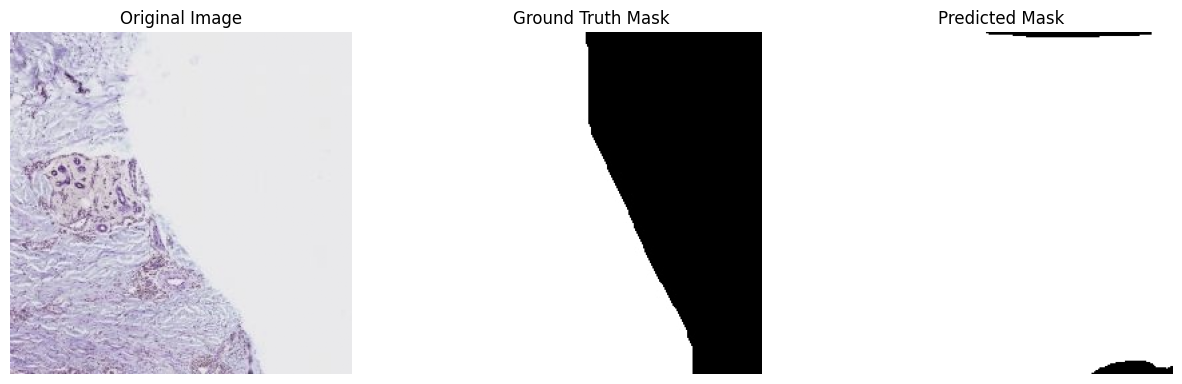

In [26]:
# Set model to evaluation mode
model_res.eval()

# Plot three random samples
for _ in range(3):
    # Get a random sample from the validation set
    sample = val_dataset[random.randint(0, len(val_dataset))]

    # Extract image and mask
    image = sample['image'].unsqueeze(0)  # Add batch dimension
    mask = sample['mask'].unsqueeze(0)    # Add batch dimension

    # Make prediction
    with torch.no_grad():
        prediction = model_res(image)

    # Convert prediction to binary mask
    predicted_mask = torch.sigmoid(prediction) > 0.5

    # Plot the images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image.squeeze(0).permute(1, 2, 0))
    axes[0].set_title('Original Image')

    axes[1].imshow(mask.squeeze(0).squeeze(0), cmap='gray')
    axes[1].set_title('Ground Truth Mask')

    axes[2].imshow(predicted_mask.squeeze(0).squeeze(0), cmap='gray')
    axes[2].set_title('Predicted Mask')

    for ax in axes:
        ax.axis('off')

    plt.show()


In [29]:
# Load a UNet with pre-trained ImageNet weights
model_pre = smp.Unet('resnet34', in_channels=3, classes=1, encoder_weights='imagenet')

In [30]:
num_epochs = 10

In [31]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_pre.parameters(), lr=0.001)
val_losses = []
AV_val_losses = []

In [32]:
for epoch in range(num_epochs):
    model_pre.train()
    for i, batch in enumerate(train_loader):
        images, masks = batch['image'], batch['mask']
        outputs = model_pre(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress
        # print(f'Training Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    model_pre.eval()
    val_losses = []
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            images, masks = batch['image'], batch['mask']
            outputs = model_pre(images)
            val_loss = criterion(outputs, masks)
            val_losses.append(val_loss.item())

            # Print progress
            # print(f'Validation Batch [{i+1}/{len(val_loader)}], Val Loss: {val_loss.item():.4f}')

    avg_val_loss = sum(val_losses) / len(val_losses)
    AV_val_losses.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch [1/10], Loss: 0.2711, Val Loss: 5.2415
Epoch [2/10], Loss: 0.2282, Val Loss: 1.2501
Epoch [3/10], Loss: 0.1715, Val Loss: 0.7676
Epoch [4/10], Loss: 0.1918, Val Loss: 0.1179
Epoch [5/10], Loss: 0.1001, Val Loss: 0.3446
Epoch [6/10], Loss: 0.1364, Val Loss: 0.3939
Epoch [7/10], Loss: 0.0848, Val Loss: 0.2363
Epoch [8/10], Loss: 0.1030, Val Loss: 0.1316
Epoch [9/10], Loss: 0.0728, Val Loss: 0.0785
Epoch [10/10], Loss: 0.1563, Val Loss: 0.1899


In [33]:
torch.save(model_pre.state_dict(), 'segmentation_model_pre.pth')

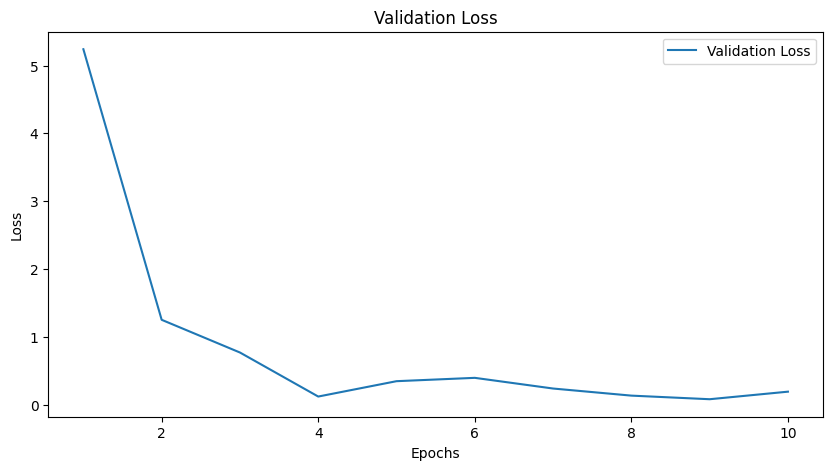

In [34]:
import matplotlib.pyplot as plt

# ... (your existing code)

# After training loop
# Plot validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), AV_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

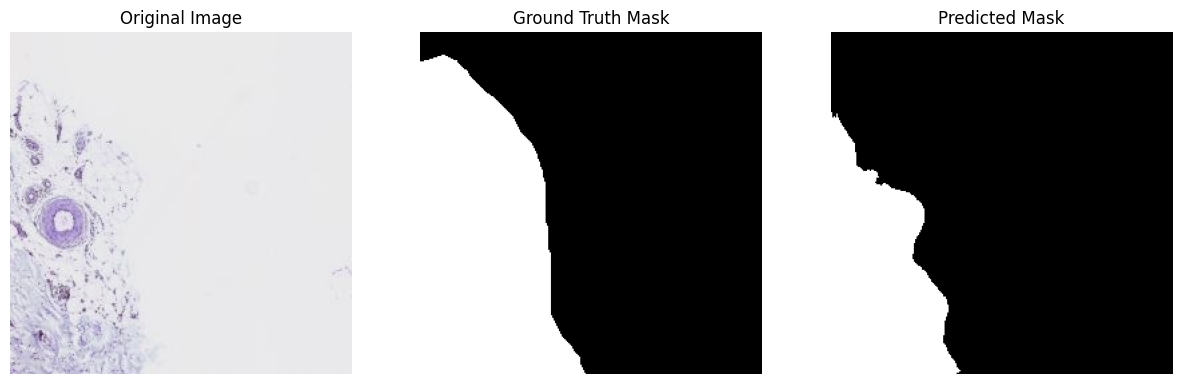

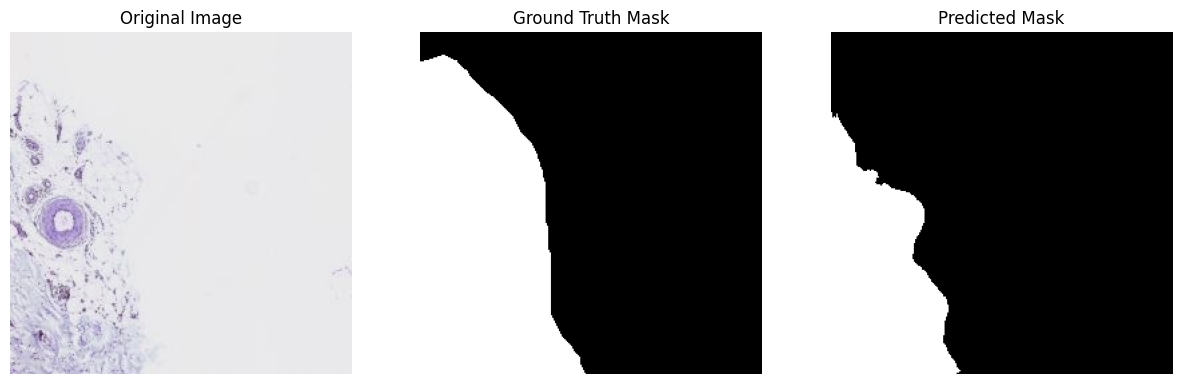

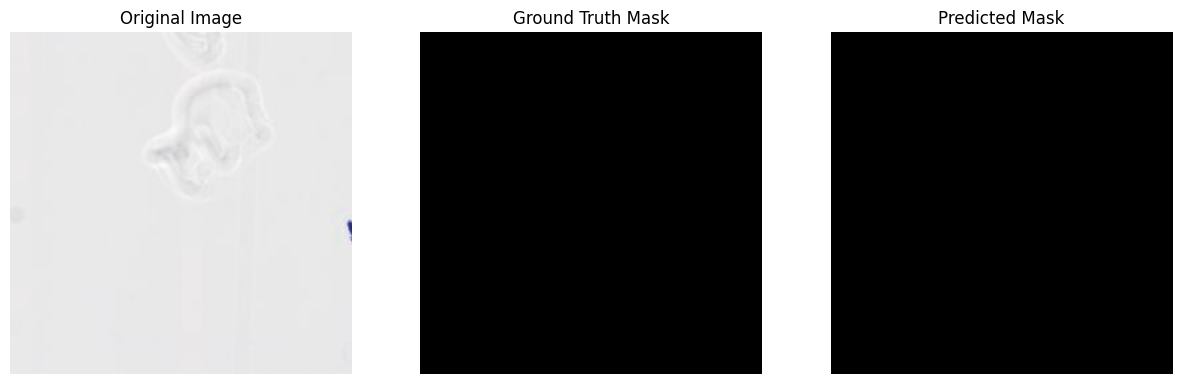

In [39]:
# Set model to evaluation mode
model_pre.eval()

# Plot three random samples
for _ in range(3):
    # Get a random sample from the validation set
    sample = val_dataset[random.randint(0, len(val_dataset))]

    # Extract image and mask
    image = sample['image'].unsqueeze(0)  # Add batch dimension
    mask = sample['mask'].unsqueeze(0)    # Add batch dimension

    # Make prediction
    with torch.no_grad():
        prediction = model_pre(image)

    # Convert prediction to binary mask
    predicted_mask = torch.sigmoid(prediction) > 0.5

    # Plot the images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image.squeeze(0).permute(1, 2, 0))
    axes[0].set_title('Original Image')

    axes[1].imshow(mask.squeeze(0).squeeze(0), cmap='gray')
    axes[1].set_title('Ground Truth Mask')

    axes[2].imshow(predicted_mask.squeeze(0).squeeze(0), cmap='gray')
    axes[2].set_title('Predicted Mask')

    for ax in axes:
        ax.axis('off')

    plt.show()
